# Use the pure pytorch tensor data structure to build the same but with auto differentiation primitives

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [34]:
def plot_3d(comp, graph_title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(graph_title)
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [35]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed instead of np.random.seed(2232) use Torch
torch.manual_seed(2232)

# Generating X with 3 dimentions
X = torch.rand((n, inputs_dimensions)).uniform_(-1,1)
print('Sample Value for X:' + str(X[:3]))

# Generating the value of the y_true
weights_true = np.array([[4., 3., -2.],[-1., -1., 3.]])
bias_true = np.array([[1],[1]])

y_true = (9. * X ** 2.) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Sample Value for y:'+ str(y_true[:3]))


Sample Value for X:tensor([[ 0.6869, -0.6098,  0.8382],
        [ 0.2776, -0.7326,  0.4000],
        [ 0.0560,  0.3198, -0.9075]])
Sample Value for y:tensor([[14.6238, 14.8144],
        [13.4994,  1.4501],
        [-7.9519, 19.1902]], dtype=torch.float64)


# Plotting the data in a 3-Dimentional Plane

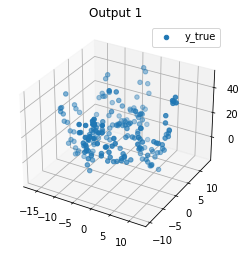

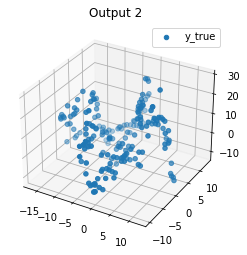

In [36]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [37]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print(inputs)
print(outputs)

3
2


# Defining activation function

In [38]:
class Relu:
    def __init__(self):
        self.input = torch.tensor([])

    def forward(self, input):
        self.input = input
        self.output = torch.clamp(self.input, min=0)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return (self.input > 0) * upstream_gradient
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

# Defining Mean Squared Error

In [39]:
# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Defining various Layers of Neural Network

In [40]:
class Layer:
    def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        # Init layer with random weights and bias
        self.weights = torch.rand((num_input_nodes, num_output_nodes), requires_grad=True)
        self.bias = torch.rand((1), requires_grad=True)
        self.X = torch.ones((num_input_nodes))
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X
        self.Z = self.X @ self.weights + self.bias
        self.weights.retain_grad()
        self.bias.retain_grad()
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    def backward(self):
        self.dJdW = self.weights.grad
        self.dJdb = self.bias.grad

    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

# Defining the Neural Net Model

In [41]:
class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        # Print network architecture for debugging
        print('Neural Net Architecture:')
        for i, layer in enumerate(self.layers):
            print('=== Layer {} ==='.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs
        for l in self.layers:
            curr_out = l.forward(curr_out)

        return curr_out
  
    def backward(self, y_pred, y_true):
        external_grad = torch.ones(y_true.shape)

        # Start with gradient from loss function wrt prediction
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred.detach().numpy()))
        error.backward(gradient=external_grad, retain_graph=True)

        for layer in reversed(self.layers):
            layer.backward()
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)
  
    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Training with Activation function RELU
With RELU as activation function we see that there is a considerable decrease in the error as the training proceeds.

In [42]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
=== Layer 1 ===
=== Layer 2 ===

Error:  235.0953531062092
Error:  180.20149421504408
Error:  161.3064450380253
Error:  173.19567331051573
Error:  158.3055903573978
Error:  179.54453301206973
Error:  147.88025255990914
Error:  150.37527255871174
Error:  151.14200643182807
Error:  162.4096153936876
Error:  148.14182360467703
Error:  153.9074208890289
Error:  147.67903349633912
Error:  152.59982084295123
Error:  145.73653318300185
Error:  147.96951122778316
Error:  144.21289427283966
Error:  144.905535702754
Error:  142.5506820818758
Error:  142.24646233450997
Error:  140.44327299235314
Error:  139.48358975822745
Error:  138.16578763667252
Error:  137.0094283105012
Error:  135.84719824050376
Error:  134.63685155039772
Error:  133.31476374517868
Error:  132.00409305587516
Error:  130.68169803356483
Error:  129.37083831260998
Error:  128.01246217554643
Error:  126.75532911303937
Error:  125.48618704165139
Error:  124.22180249734197
Error:  122.98381

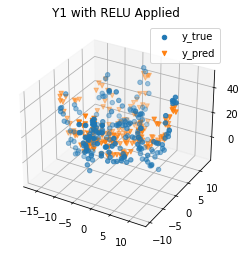

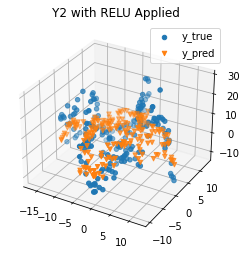

In [43]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU Applied', X, y_true[:,1], y_pred[:,1])